In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-ul3rs5h8
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-ul3rs5h8
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit afd9cfd062b60ca1ba8d7c9daef7dc820489db0a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for chronos: filename=chronos-1.2.0-py3-none-any.whl size=13875 sha256=36e903f2cb544105a94c783be7134038b9bda290dd6ec6386077d8d1b9c8a13d
  Stored in directory: /tmp/pip-ephem-wheel-cache-_rwicgvo/wheels/bf/c1/65/08857e57345ef1b34ba0edb4791f1b2594943e82f34e93a4ab
Successfully built chronos


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-large",
  device_map="cuda",
  torch_dtype=torch.bfloat16,
)

df = pd.read_csv("/kaggle/input/six-machine-oscillations/PWB1 VM 2500.csv")


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [14]:
start_time = '2023-01-01 00:00:00'
date_range = pd.date_range(start=start_time, periods=len(df), freq='S')

# Add the DateTime column to the DataFrame
df['DateTime'] = date_range

# Reorder columns if necessary
df = df[['DateTime', 'V1']]

/tmp/ipykernel_34/3886119402.py:2: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  date_range = pd.date_range(start=start_time, periods=len(df), freq='S')
/tmp/ipykernel_34/3886119402.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DateTime'] = date_range


In [15]:
df.head()

,DateTime,V1
0,2023-01-01 00:00:00,2
1,2023-01-01 00:00:01,9
2,2023-01-01 00:00:02,-13
3,2023-01-01 00:00:03,4
4,2023-01-01 00:00:04,12


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='DateTime', ylabel='V1'>

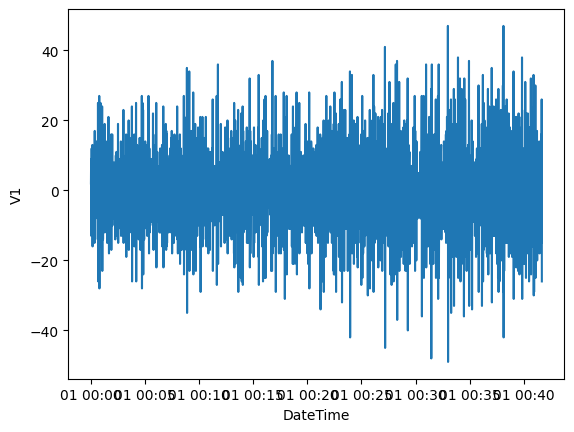

In [16]:
import seaborn as sns
sns.lineplot(data=df, x='DateTime', y = 'V1')

In [25]:
context = torch.tensor(df["V1"])
prediction_length = 64
forecast = pipeline.predict(context, prediction_length)  # shape [num_series, num_samples, prediction_length]

# visualize the forecast
forecast_index = range(len(df.head(100)), len(df.head(100)) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)


In [31]:
forecast.reshape(-1,1)

tensor([[ 23.9811],
        [-18.0854],
        [ 16.9700],
        ...,
        [  1.9918],
        [  7.9671],
        [  3.0275]])

<Figure size 1000x700 with 0 Axes>

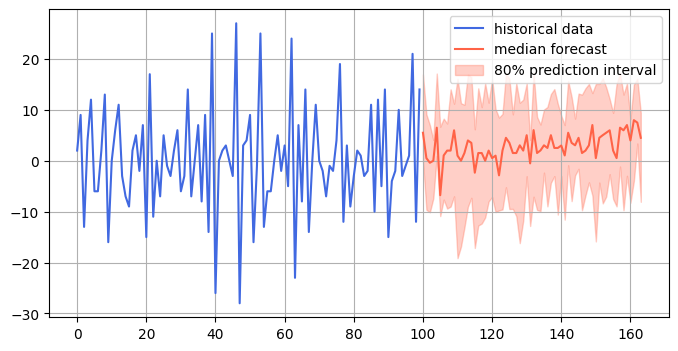

In [26]:
plt.figure(figsize=(10,7))
# visualize the results
plt.figure(figsize=(8, 4))
plt.plot(df['V1'].head(100), color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show();

In [24]:
low

array([ -0.19917853, -12.12599688, -11.1460371 ,  -4.30225909,
        -4.04731054, -10.38119135,  -6.65256724, -11.02653046,
       -18.61125431,  -8.26989794, -19.40000172,  -6.69240303,
       -13.18562794,  -8.96303921, -12.74743347, -16.34061642,
       -10.91499043, -15.1455451 , -12.90677681,  -9.60837841,
        -2.3821769 ,  -6.81987734,  -9.50480547,  -4.15885067,
       -10.37322454,  -3.41790578, -10.070473  , -10.33338881,
        -9.87129402, -18.65905762,  -9.40123272, -11.32928181,
        -9.63227997, -17.67113152,  -9.73585234, -15.33675613,
        -8.92320347,  -7.05092425,  -9.40919981,  -8.12648964,
       -12.0542922 , -14.92246542,  -3.18685865,  -1.86431231,
       -18.18102818,  -9.46496992, -10.62020645, -11.01856384,
        -9.03474388, -10.89108944,  -3.07531855,   1.89618096,
        -6.57289577,  -9.32156134, -11.55236168, -10.07844048,
        -6.24624295,  -6.89158158,  -2.40607829, -10.62020645,
        -9.89519596,  -1.06759776,  -7.2102674 ,  -0.75